## Validate CA3 projections in CA1 microcircuit

In [1]:
import json
from pathlib import Path

import nrrd 
import matplotlib.pyplot as plt
# package to work with the circuit
from bluepysnap import Circuit

In [2]:
circuit_path = '/home/tdelemon/1.Workdir/tests/mooc-106/circuit/circuit_config.json'
circuit = Circuit(circuit_path)

In [3]:
print(list(circuit.nodes))
print(list(circuit.edges))

['hippocampus_projections', 'hippocampus_neurons']
['hippocampus_neurons__hippocampus_neurons__chemical', 'hippocampus_projections__hippocampus_neurons__chemical']


In [4]:
cells = circuit.nodes["hippocampus_neurons"]
conn = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical"]
proj_cells =circuit.nodes["hippocampus_projections"]
proj_conn =circuit.edges["hippocampus_projections__hippocampus_neurons__chemical"]

### Number of synapse per connection

In [20]:
pre = proj_cells.ids()
post = cells.ids()
data = np.array([p[2] for p in proj_conn.iter_connections(pre, post, return_edge_count=True)])

In [24]:
# data is the number of connections between 2 neurons
nsyns = np.unique(data, return_counts=True)
# nsyns is the number of neuron pairs having exactly n number of shared synapses
print(nsyns)

(array([1, 2, 3, 4, 5, 6, 7], dtype=uint32), array([29617615,  1995541,    98384,     4007,      154,        7,
              1]))


/home/tdelemon/.virtualenvs/mooc/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


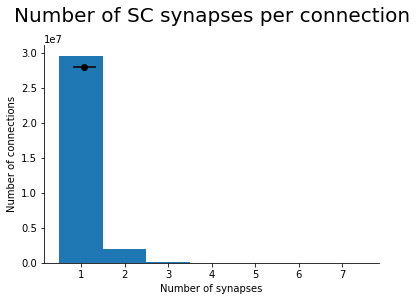

In [25]:
# plot
fig, ax = plt.subplots()


ax.hist(nsyns[0], bins=np.append(nsyns[0], nsyns[0][-1]+1)-0.5, weights=nsyns[1])
# ax.set_xticks(nsyns)

_, y1 = ax.get_ylim()
mean = data.mean()
std = data.std()
ax.errorbar(mean, y1*0.9, xerr=std, color='k', fmt='o')

ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
ax.set_title('Number of SC synapses per connection', fontsize=20, y=1.08)
ax.set_xlabel('Number of synapses')
ax.set_ylabel('Number of connections')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.show()

### Distribution across layers

In [26]:
# To get all edge ids you just need to know the size of the edge population
all_edge_ids = np.arange(proj_conn.size)
print(all_edge_ids)

[       0        1        2 ... 33920693 33920694 33920695]


In [27]:
# we can print all the properties from the edge file
print(proj_conn.property_names)

{'syn_type_id', 'n_rrp_vesicles', 'conductance', 'afferent_section_id', 'depression_time', 'afferent_segment_offset', 'afferent_segment_id', 'afferent_center_z', 'delay', 'u_syn', 'afferent_center_x', 'facilitation_time', 'decay_time', 'afferent_center_y'}


In [28]:
atlas_directory = '/gpfs/bbp.cscs.ch/project/proj42/entities/dev/atlas/O1-243'
br_data, br_metadata = nrrd.read(Path(atlas_directory, "brain_regions.nrrd"))

# hierarchy contains the region hierarchy: 01 -> [mc0->[mc0;SO, mc0;SP, ...], mc1-> [mc1;SO, mc1;SP, ...], ...]
hierarchy = json.load(open(Path(atlas_directory, "hierarchy.json")))

In [29]:
id_layer_map = {}
for column in hierarchy["children"]:
    for region in column["children"]:
        id_ = region["id"]
        layer = region["acronym"].split(";")[-1]
        id_layer_map[id_] = layer
id_layer_map[0] = 'out'

In [30]:
spacing = br_metadata["space directions"].diagonal()
offset = br_metadata["space origin"]
properties = ['afferent_center_x', 'afferent_center_y', 'afferent_center_z']
synapses = proj_conn.properties(all_edge_ids, properties=properties)
synapses.rename(columns={"afferent_center_x": "x", "afferent_center_y": "y", "afferent_center_z": "z"}, inplace=True)

positions = proj_conn.positions(all_edge_ids, "afferent", "center").to_numpy()
indices = np.array((positions - offset) / spacing, dtype=int)
labels = br_data[tuple(indices.T)]
def _apply_mapping(x):
    return id_layer_map[x]

apply_mapping = np.vectorize(_apply_mapping)
layers = apply_mapping(labels)
synapses['layer'] = layers

In [12]:
synapses.head()

,x,y,z,layer
0,401.123138,507.465424,1080.862549,SR
1,401.029205,507.618988,1080.988281,SR
2,410.541321,505.417938,1063.080444,SR
3,414.326447,502.274017,1067.086670,SR
4,402.465637,505.989532,1078.359619,SR


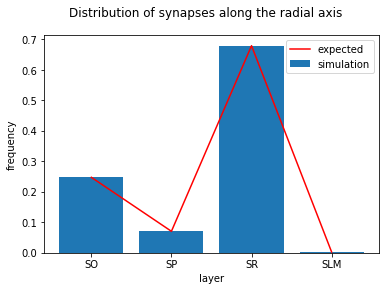

In [31]:
# model distribution
layers = ['SO', 'SP', 'SR', 'SLM']
mod_y_distr = np.array([np.count_nonzero(synapses.layer==layer) for layer in layers], dtype=np.float32)
mod_y_distr = mod_y_distr/mod_y_distr.sum()
exp_y_distr = [0.2476014415, 0.0705293209, 0.6792951748, 0.0025740628]
x = np.arange(4)
fig, ax = plt.subplots()
ax.bar(x, mod_y_distr, label='simulation')
ax.plot(x,exp_y_distr,color='r', label='expected')
plt.xticks(x, layers)
fig.suptitle('Distribution of synapses along the radial axis')
ax.set_xlabel('layer')
ax.set_ylabel('frequency')
plt.legend(loc='upper right')
plt.show()

### Distribution over XZ plane

Verify that the synapses are distributed uniformly in the XZ plane

[]

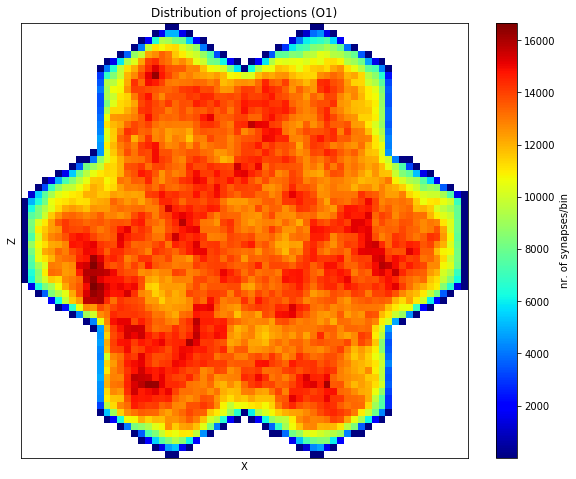

In [32]:
# convert to density matrix
xyz = synapses[["x", "y", "z"]]

import numpy as np
def bin_space(x, y, x_min, x_max, y_min, y_max, bin_size):
    """"Bins the space for 'density plot'"""
    x_bins = np.arange(x_min, x_max, bin_size)
    y_bins = np.arange(y_min, y_max, bin_size)
    x_bins = np.append(x_bins, x_max)
    y_bins = np.append(y_bins, y_max)
    X = np.zeros((len(x_bins)-1, len(y_bins)-1))

    for i, (_x_min, _x_max) in enumerate(zip(x_bins[0:-1], x_bins[1:])):
        idx_x = np.where((_x_min < x) & (x <= _x_max))[0]
        for j, (_y_min, _y_max) in enumerate(zip(y_bins[0:-1], y_bins[1:])):
            idx_y = np.where((_y_min < y[idx_x]) & (y[idx_x] <= _y_max))[0]
            X[i, j] = len(idx_y)
        
    X[np.where(X == 0)] = np.nan
    return X

x_min = -260.0; x_max = 980.0
z_min = -20.0; z_max = 1280.0
bin_size = 20
dens_O1 = bin_space(xyz["x"].values, xyz["z"].values, x_min, x_max, z_min, z_max, bin_size)

# plt
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
i = ax.imshow(dens_O1, cmap="jet", aspect="auto", interpolation="nearest", origin="lower")
fig.colorbar(i, label="nr. of synapses/bin")
ax.set_title("Distribution of projections (O1)")
ax.set_xlabel("X"); ax.set_ylabel("Z")
ax.set_xticks([]); ax.set_yticks([])